In [2]:
# Setup

# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
from pymc3.gp.util import plot_gp_dist
import time
import pickle

In [3]:
# Read in metabolomics data
mbx = pd.read_csv('./data/iHMP_labled_metabolomics.csv')
# Subset metabolites to labeled sets
mbx = mbx[pd.notnull(mbx.Metabolite)]
# Get metabolite list
mbx_list = mbx.Metabolite
# Reshape metabolites for merge
mbx = mbx.iloc[:,7:].transpose().rename(columns = mbx_list)

# Read in metadata for timing of samples
meta = pd.read_csv('./data/iHMP_metadata.csv')
# Subset metadata to appropriate samples and columns of interest
meta = meta[meta['External ID'].isin(mbx.index)][['External ID', 'Participant ID', 
                                                  'date_of_receipt', 'diagnosis',
                                                  'hbi']]
meta.set_index('External ID', inplace = True)

/Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (12,13,14,40,46,55,65,66,67,68,177,294,298,299,300,301,304,305,306,307,308,309,310,318,320,328,330,346,348,350,352,354,359,361,363,366,373,377,381,383,418,419,432,433,434,435,436,438,439,440,441,442,444,445,446,447,448,450,451,452,453,454) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# Make sure that intensities are numeric and log transform them
log_mbx = np.log(mbx.astype('double'))

# Calculate the means and standard deviations of each column
log_means = log_mbx.mean()
log_stds = log_mbx.std()

# Transform dataset
log_mbx = (log_mbx - log_means)/log_stds

# Merge metabolomics info to metadata
df = (meta.merge(log_mbx, left_index = True, 
           right_index = True).
      drop_duplicates().
      rename(columns = {'Participant ID': 'id',
                        'date_of_receipt': 'date'#,
#                         0: 'intensity'
                       }))

# Fix the date column
df.date = pd.to_datetime(df.date)

# Now scale the dates compared to the earliest date
min_date = df.date.min()
df['days_from_start'] = (df.date - min_date).dt.days

# Drop columns that aren't needed (drop id for the moment)
df = df.drop(columns=['date'])#, 'id'])

# Drop duplicate metabolites
df = df.loc[:,~df.columns.duplicated()]

# Only keep CD observations because they have hbi
df = df.query("diagnosis == 'CD'").drop(columns = ['diagnosis'])

# Only keep non-missing HBI for the moment
df = df[df.hbi.notna()]

# Standardize hbi and days for convergence properties
# df.days_from_start = (df.days_from_start - df.days_from_start.mean())/df.days_from_start.std()
# df.hbi = (df.hbi - df.hbi.mean())/df.hbi.std()


print(df.shape)
df.head()

(241, 554)


,id,hbi,12.13-diHOME,9.10-diHOME,caproate,heptanoate,hydrocinnamate,mandelate,2-hydroxyoctanoate,3-hydroxyoctanoate,...,C16:1 LPC plasmalogen,C18:1 LPC plasmalogen,C18:0 LPE-A,C18:0 LPE-B,C22:6 LPE,sphingosine-isomer1,sphingosine-isomer2,sphingosine-isomer3,C14:0 SM,days_from_start
CSM5FZ3N,C3001,4.0,-0.409704,0.183670,0.003310,NaN,-0.610070,-0.303162,NaN,-0.158171,...,-0.369853,0.066557,-0.444861,-0.316974,-1.059765,1.948904,1.733310,-0.765078,-0.132560,93
CSM5FZ3T,C3002,9.0,-1.244306,-1.342266,-1.831472,NaN,-1.231499,-0.186689,NaN,0.173428,...,0.800807,1.086874,1.026001,0.343527,0.431995,0.842126,-0.618901,1.792141,0.477922,139
CSM5FZ44,C3002,7.0,-0.732257,-0.025969,-0.676471,NaN,-1.390449,1.101909,NaN,0.228417,...,-1.333244,-1.337533,-0.288112,-0.987577,-0.147020,1.038184,-0.216658,0.596926,NaN,195
CSM5FZ4C,C3001,3.0,-0.982568,0.583898,0.024073,NaN,-0.293677,0.593005,NaN,0.500679,...,-0.993211,-0.517254,-0.073573,0.967467,-0.495222,1.279855,1.182091,-0.441937,0.047485,149
CSM5MCU4,C3008,0.0,-0.524664,-0.258498,0.128297,NaN,-1.070318,-0.267726,-0.406852,0.965806,...,-0.333367,-0.003440,-0.108772,-1.055471,-0.179870,-1.351587,-1.077767,-0.445793,1.059403,202


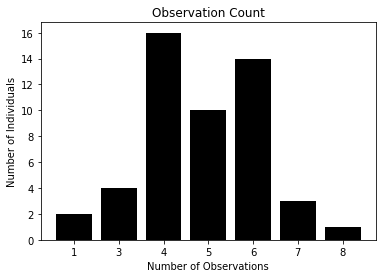

In [5]:
import seaborn as sns
count_df = df.id.value_counts().value_counts()

g = sns.barplot(x = count_df.index, y = count_df, color='black')
g.set_title('Observation Count')
g.set_xlabel('Number of Observations')
g.set_ylabel('Number of Individuals')
plt.plot();

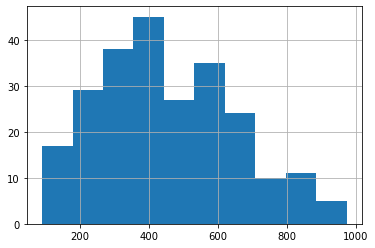

In [6]:
df.days_from_start.hist()

In [7]:
df.hbi.unique()

array([ 4. ,  9. ,  7. ,  3. ,  0. ,  1. ,  2. ,  5. , 12. ,  8. ,  6. ,
       18. , 13. ,  0.5])

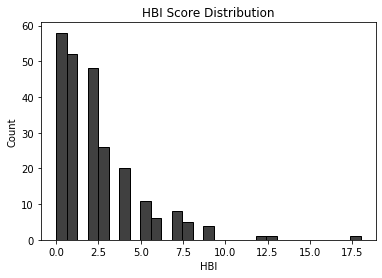

In [8]:
g = sns.histplot(df.hbi, color='black')
g.set_xlabel('HBI')
g.set_title('HBI Score Distribution');

In [9]:
df.head()

,id,hbi,12.13-diHOME,9.10-diHOME,caproate,heptanoate,hydrocinnamate,mandelate,2-hydroxyoctanoate,3-hydroxyoctanoate,...,C16:1 LPC plasmalogen,C18:1 LPC plasmalogen,C18:0 LPE-A,C18:0 LPE-B,C22:6 LPE,sphingosine-isomer1,sphingosine-isomer2,sphingosine-isomer3,C14:0 SM,days_from_start
CSM5FZ3N,C3001,4.0,-0.409704,0.183670,0.003310,NaN,-0.610070,-0.303162,NaN,-0.158171,...,-0.369853,0.066557,-0.444861,-0.316974,-1.059765,1.948904,1.733310,-0.765078,-0.132560,93
CSM5FZ3T,C3002,9.0,-1.244306,-1.342266,-1.831472,NaN,-1.231499,-0.186689,NaN,0.173428,...,0.800807,1.086874,1.026001,0.343527,0.431995,0.842126,-0.618901,1.792141,0.477922,139
CSM5FZ44,C3002,7.0,-0.732257,-0.025969,-0.676471,NaN,-1.390449,1.101909,NaN,0.228417,...,-1.333244,-1.337533,-0.288112,-0.987577,-0.147020,1.038184,-0.216658,0.596926,NaN,195
CSM5FZ4C,C3001,3.0,-0.982568,0.583898,0.024073,NaN,-0.293677,0.593005,NaN,0.500679,...,-0.993211,-0.517254,-0.073573,0.967467,-0.495222,1.279855,1.182091,-0.441937,0.047485,149
CSM5MCU4,C3008,0.0,-0.524664,-0.258498,0.128297,NaN,-1.070318,-0.267726,-0.406852,0.965806,...,-0.333367,-0.003440,-0.108772,-1.055471,-0.179870,-1.351587,-1.077767,-0.445793,1.059403,202


In [10]:
df.days_from_start.describe()

count    241.000000
mean     454.751037
std      198.631265
min       91.000000
25%      301.000000
50%      421.000000
75%      587.000000
max      973.000000
Name: days_from_start, dtype: float64

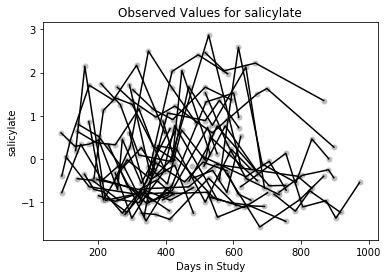

In [57]:
sns.lineplot(#data = df[['id', 'salicylate', 'days_from_start']],
             x=df.days_from_start,
             y=df.salicylate,
             units=df.id,
             estimator=None,
             color='black',
#              alpha=0.25,
             legend=False)

g = sns.scatterplot(x=df.days_from_start,
             y=df.salicylate,
#              hue=df.id,
                    color='black',
                    alpha=0.25,
             legend=False)

g.set_title('Observed Values for salicylate')
g.set_xlabel('Days in Study')
g.plot();